In [1]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import re
import fastai

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)


1.8.0
4.20.1
2.7.7


In [2]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
text = """ 옛날 옛날 어느 마을에 흥부와 놀부 형제가 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
c:\ProgramData\Anaconda3\envs\readvice\lib\site-packages\transformers\models\auto\modeling_auto.py:969: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


옛날 옛날 어느 마을에 흥부와 놀부 형제가 왁자지껄 떠들어대며 "우리 집엔 왜 이렇게 많은 사람들이 모여 사는 거야?" 하고 묻는다.
그런데 그 마을 사람들은 모두 다들 자기네 동네에 살고 있는 사람들이라고 한다.
이렇게 해서 우리 마을은 '흥부가 살던 곳'이라는 뜻의 '고향'이 되었다.
그리고 이 고향은 바로 지금의 서울 종로구 숭인동이다.
숭인동은 원래 종로에서 가장 오래된 주택가였다.
1970년대까지만 해도 이곳은 재개발로 인해 헐리고 빈집이 많아졌다.
하지만 1980년대 들어 다시 활기를 되찾기 시작했다.
당시만 하더라도 이곳에는 낡은 건물들이 많이 남아 있었다.
그러나 1990년대 들어서부터는 예전의


In [3]:
# import pandas as pd
# import re
# from icecream import ic
#
# df = pd.read_csv('./data/24_reivews_test.csv', index_col=0)
# df.duplicated().sum()
# df.drop_duplicates(inplace=True)
# # df.to_csv('./data/reviews.txt', index=False)

In [4]:
with open('./data/reviews.txt', encoding='utf-8') as f:
    lines = f.read()
lines=" ".join(lines.split())
print(len(lines))
lines = lines.replace('\n|\t', ' ')
hangul = re.compile('[^ ㄱ-ㅣ가-힣+]')
print(len(lines))
result = hangul.sub('',lines)
print(len(result))
# UnicodeDecodeError: 'cp949' codec can't decode byte 0xec in position 20: illegal multibyte sequence
# 해당 에러 ->  encoding='utf-8' 넣어 주기

1692433
1692433
1592406


In [5]:

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=result[:int(len(result)*0.9)]
test=result[int(len(result)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=4, seq_len=seq_len)

SuggestedLRs(valley=9.120108734350652e-05)


epoch,train_loss,valid_loss,perplexity,time
0,4.426782,4.260643,70.855530,02:29
1,4.283282,4.233506,68.958595,02:29
2,4.144680,4.233999,68.992599,02:30
3,3.990840,4.289129,72.902962,02:30
4,3.808237,4.373501,79.320869,02:30
5,3.607110,4.501252,90.129921,02:29
6,3.380082,4.632193,102.739082,02:30
7,3.139997,4.772295,118.190231,02:29
8,2.874776,4.935365,139.123947,02:29
9,2.611105,5.036846,153.983612,02:30


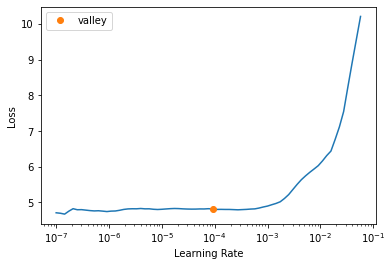

In [6]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(50, lr)
# learn.fine_tune(30)

In [10]:
prompt='경제'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,
                           use_cache=True
                          )
tokenizer.decode(preds[0].cpu().numpy())

'경제경제 성장률 금리 인구 공급이 이전보다 많아진다는 뜻이다 년 외환위기 이후 최고치라고 전문가들은 입을 모은다 경제학 서적에서나 접하던 인플레이션의 망령이 우리의 일상을 위협하기 시작하는 것이리라 본다가글쓴이는 여기에 주목해 끝을 모르고 올라가는 물가에 대응할 수 있는 혜안과 예측능력을 독자들에게 선사한다한익히 모르는 사이에 배운 내용이지만 저자의 말처럼 그물은 이미 알고 있고 경험도 했지만 누구도 예측할 순 없지만 그때에도 당황하지 않고 현명하게 대처하는 방법을 배우며 어렵고 복잡한 세계사를 공부한다면 어렵게만 느껴졌던세계사에 대한 지식이 더욱 깊어질 것으로 보인다고본다이 책은 특히 코'

In [ ]:
learn.model.save_pretrained("./models/kogpt2_bookreport_backup50")